# Ising MUCA

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Random
using StatsBase
using Plots
using MonteCarloX
using SpinSystems
using MPI
using Distributed

if !MPI.Initialized()
    required = MPI.THREAD_FUNNELED
    provided = MPI.Init_thread(required)
    if provided < required
        error("MPI thread support insufficient: required THREAD_FUNNELED, got level $(provided).")
    end
end
comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)
nprocs_mpi = MPI.Comm_size(comm)
mpi_thread_level = MPI.Query_thread()
rank == 0 && println("MPI ranks=", nprocs_mpi, ", MPI thread level=", mpi_thread_level)

  Activating project at `~/.julia/dev/MonteCarloX/notebooks`


MPI ranks=1, MPI thread level=MPI.ThreadLevel(1)


## Exact Beale solution as a reference

In [2]:
L = 8
N = L * L

log_dos_beale_8x8 = [
    (-128, 0.6931471805599453), (-120, 4.852030263919617), (-116, 5.545177444479562),
    (-112, 8.449342524508063), (-108, 9.793672686528922), (-104, 11.887298863200714),
    (-100, 13.477180596840947), (-96, 15.268195474147658), (-92, 16.912371686315282),
    (-88, 18.59085846191256), (-84, 20.230089202801466), (-80, 21.870810400320693),
    (-76, 23.498562234123614), (-72, 25.114602234581373), (-68, 26.70699035290573),
    (-64, 28.266152815389898), (-60, 29.780704423363996), (-56, 31.241053997806176),
    (-52, 32.63856452513369), (-48, 33.96613536105969), (-44, 35.217576663643314),
    (-40, 36.3873411250109), (-36, 37.47007844691906), (-32, 38.46041522581422),
    (-28, 39.35282710786369), (-24, 40.141667825183845), (-20, 40.82130289691285),
    (-16, 41.38631975325592), (-12, 41.831753810069756), (-8, 42.153328313883975),
    (-4, 42.34770636939425), (0, 42.41274640460084), (4, 42.34770636939425),
    (8, 42.153328313883975), (12, 41.831753810069756), (16, 41.38631975325592),
    (20, 40.82130289691285), (24, 40.141667825183845), (28, 39.35282710786369),
    (32, 38.46041522581422), (36, 37.47007844691906), (40, 36.3873411250109),
    (44, 35.217576663643314), (48, 33.96613536105969), (52, 32.63856452513369),
    (56, 31.241053997806176), (60, 29.780704423363996), (64, 28.266152815389898),
    (68, 26.70699035290573), (72, 25.114602234581373), (76, 23.498562234123614),
    (80, 21.870810400320693), (84, 20.230089202801466), (88, 18.59085846191256),
    (92, 16.912371686315282), (96, 15.268195474147658), (100, 13.477180596840947),
    (104, 11.887298863200714), (108, 9.793672686528922), (112, 8.449342524508063),
    (116, 5.545177444479562), (120, 4.852030263919617), (128, 0.6931471805599453)
]
exact_logdos = Dict(log_dos_beale_8x8);
# make a logweight out of the exact log-DOS for RMSE calculation
exact_logdos = TabulatedLogWeight(Histogram(push!([e for (e, _) in log_dos_beale_8x8],132), [w for (_, w) in log_dos_beale_8x8]))

TabulatedLogWeight{Float64, 1, Tuple{Vector{Int64}}}(Histogram{Float64, 1, Tuple{Vector{Int64}}}
edges:
  [-128, -120, -116, -112, -108, -104, -100, -96, -92, -88  …  92, 96, 100, 104, 108, 112, 116, 120, 128, 132]
weights: [0.6931471805599453, 4.852030263919617, 5.545177444479562, 8.449342524508063, 9.793672686528922, 11.887298863200714, 13.477180596840947, 15.268195474147658, 16.912371686315282, 18.59085846191256  …  18.59085846191256, 16.912371686315282, 15.268195474147658, 13.477180596840947, 11.887298863200714, 9.793672686528922, 8.449342524508063, 5.545177444479562, 4.852030263919617, 0.6931471805599453]
closed: left
isdensity: false)

In [3]:
function rmse_exact(lw::TabulatedLogWeight)
    @assert lw.histogram.edges[1] == exact_logdos.histogram.edges[1] "Energy bins of logweight and exact log-DOS do not match."
    est = -Float64.(lw.histogram.weights)
    ref = Float64.(exact_logdos.histogram.weights)
    energies = lw.histogram.edges[1][1:end-1]
    i0 = findfirst(==(0), energies)
    if i0 !== nothing && isfinite(ref[i0])
        est .-= est[i0]
        ref .-= ref[i0]
    end
    idx = findall(i -> isfinite(ref[i]) && isfinite(est[i]), eachindex(energies))
    return sqrt(mean((est[idx] .- ref[idx]).^2))
end

rmse_exact (generic function with 1 method)

## Plotting helper

In [11]:
function plot_from_hist_lw(hist_vec::Vector{Histogram}, lw_vec::Vector{TabulatedLogWeight}; title_prefix="")
    n = length(hist_vec)
    cols = palette(:viridis, max(n, 2))[1:n]
    energies = hist_vec[1].edges[1][1:end-1]
    
    p1 = plot(xlabel="E", ylabel="counts", title="$(title_prefix)histograms", legend=false)
    for i in 1:n
        plot!(p1, energies, hist_vec[i].weights; lw=2, color=cols[i])
    end

    p2 = plot(xlabel="E", ylabel="-logweight", title="$(title_prefix)weights", legend=false)
    for i in 1:n
        w = -Float64.(lw_vec[i].histogram.weights)
        i0 = findfirst(==(0), energies)
        if i0 !== nothing
            w .-= w[i0]
        end
        plot!(p2, energies, w; lw=2, color=cols[i])
    end
    ref_curve = Float64.(exact_logdos.histogram.weights)
    i0 = findfirst(==(0), energies)
    if i0 !== nothing && isfinite(ref_curve[i0])
        ref_curve .-= ref_curve[i0]
    end
    plot!(p2, energies, ref_curve; lw=2, color=:black, ls=:solid)

    rmse = [rmse_exact(lw) for lw in lw_vec]
    p3 = scatter(1:n, rmse; ms=4, color=:steelblue, xlabel="iter", ylabel="RMSE", title="$(title_prefix)RMSE", legend=false, yscale=:log10)  
    display(plot(p1, p2, p3, layout=(1,3), size=(980, 260), margin=4Plots.mm))
    return rmse
end

plot_from_hist_lw (generic function with 1 method)

## Serial MUCA

In [5]:
# Serial: run + collect
n_iter = 10
sweeps_therm = 100
sweeps_record = 10_000
sys = IsingLatticeOptim(L, L)
init!(sys, :random, rng=MersenneTwister(1000))
alg = Multicanonical(MersenneTwister(1000), TabulatedLogWeight(exact_logdos.histogram.edges[1], 0.0))

serial_hists = Histogram[]
serial_lws = TabulatedLogWeight[]
for _ in 1:n_iter
    for _ in 1:(sweeps_therm * length(sys.spins))
        spin_flip!(sys, alg)
    end
    # reset measurement data
    reset!(alg)
    for i in 1:(sweeps_record * length(sys.spins))
        spin_flip!(sys, alg)
    end
    update_weight!(alg; mode=:simple)
    push!(serial_hists, deepcopy(alg.histogram))
    push!(serial_lws, deepcopy(alg.logweight))
end

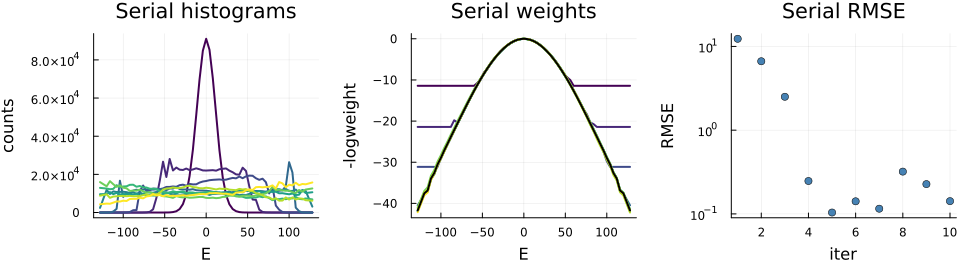

Final serial RMSE (exact) = 0.142


In [12]:
# Serial: RMSE + plot (vs exact Beale logDOS)
rmse_serial = plot_from_hist_lw(serial_hists, serial_lws; title_prefix="Serial ")
println("Final serial RMSE (exact) = ", round(last(rmse_serial), digits=4))

## MPI Version (in notebook only 1 core)

In [13]:
# MPI: run + collect (same pattern as serial)
pmuca = ParallelMulticanonical(MPI.COMM_WORLD, root=0)
sys = IsingLatticeOptim(L, L)
init!(sys, :random, rng=MersenneTwister(1000 + pmuca.rank))
alg = Multicanonical(MersenneTwister(1000 + pmuca.rank), TabulatedLogWeight(exact_logdos.histogram.edges[1], 0.0))

mpi_hists = Histogram[]
mpi_lws = TabulatedLogWeight[]

# meas_local = Measurements([:energy_hist => (s -> Int(energy(s))) => fit(Histogram, Int[], bins)], interval=1)
for _ in 1:n_iter
    for _ in 1:(sweeps_therm * length(sys.spins))
        spin_flip!(sys, alg)
    end

    reset!(alg) # reset to discard histograms from thermalization and previous iterations
    for i in 1:(sweeps_record * length(sys.spins)/pmuca.size) # each rank does 1/nprocs of the total sweeps
        spin_flip!(sys, alg) # measures histogram internally
    end
    
    # merge histogram onto root
    merge_histograms!(pmuca, alg.histogram)
    # update weight on root and store 
    if is_root(pmuca)
        update_weight!(alg; mode=:simple)
        # write
        push!(mpi_hists, deepcopy(alg.histogram))
        push!(mpi_lws, deepcopy(alg.logweight))
    end
    # distirbute updated weight to all ranks for next iteration
    distribute_logweight!(pmuca, alg.logweight)
end

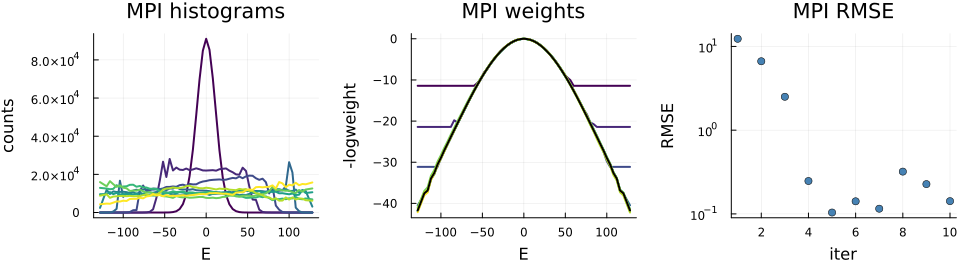

Final MPI RMSE (exact) = 0.142


In [14]:
# MPI: RMSE + plot (vs exact Beale logDOS)
if is_root(pmuca)
    rmse_mpi = plot_from_hist_lw(mpi_hists, mpi_lws; title_prefix="MPI ")
    println("Final MPI RMSE (exact) = ", round(last(rmse_mpi), digits=4))
end

## MPI Example Script
For production runs with multiple MPI ranks, use the standalone script in `examples/ising_muca_mpi.jl`.
Launch with: `mpiexec -n 4 julia --project examples/ising_muca_mpi.jl`

In [9]:
# See muca_mpi.jl for the standalone MPI script
# To run: mpiexec --host localhost -n 4 julia --project ./examples/ising_muca_mpi.jl